In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import AUC
from keras.optimizers import Adam, RMSprop
from keras.preprocessing import sequence
from keras.datasets import imdb
from keras.models import Model
from keras.layers import *
import keras.backend as K
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from sklearn import metrics
import matplotlib.pyplot as plt
from keras.models import load_model
import matplotlib.pylab as pylab
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from tensorflow.keras.metrics import AUC
from keras.optimizers import Adam, RMSprop
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import re

In [2]:
print(tf.__version__)

2.16.1


In [3]:
def roc(y_tests, y_test_scores):
    font = {'family': 'arial',
            'weight': 'bold',
            'size': 20}
    params = {'axes.labelsize': '20',
              'xtick.labelsize': '20',
              'ytick.labelsize': '20',
              'lines.linewidth': '4'}
    pylab.rcParams.update(params)
    pylab.rcParams['font.family'] = 'sans-serif'
    pylab.rcParams['font.sans-serif'] = ['Arial']
    pylab.rcParams['font.weight'] = 'bold'
    plt.figure(figsize=(7, 7), dpi=300)
    AUC = roc_auc_score(y_tests, y_test_scores)
    fpr1, tpr1, thresholds1 = roc_curve(y_tests, y_test_scores)
    plt.plot(fpr1, tpr1, linewidth='3', color='tomato', label='AUC = {:.3f}'.format(AUC))
    plt.plot([0, 1], [0, 1], linewidth='1', color='grey', linestyle="--")
    plt.yticks(np.linspace(0, 1, 6))
    plt.xticks(np.linspace(0, 1, 6))
    plt.xlim((0, 1))
    plt.ylim((0, 1))
    plt.legend(prop={'size': 20}, loc=4, frameon=False)
    plt.subplots_adjust(left=0.2, right=0.95, top=0.95, bottom=0.2)
    plt.xlabel('1–Specificity', font)
    plt.ylabel('Sensitivity', font)
    plt.savefig('E:/NingLab/object/khib/results/site_3fold_trans.jpg')
    #plt.show()


'''多头Attention'''


class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output


'''Transformer的Encoder部分'''

'Transformer的Encoder部分'

In [4]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.005):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim), ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)

        return self.layernorm2(out1 + ffn_output)


'''Transformer输入的编码层'''

'Transformer输入的编码层'

In [5]:
from tensorflow.keras.layers import Layer, Embedding
from tensorflow.keras.utils import register_keras_serializable
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [6]:
def seq2num(seqlist):
    out = []
    transdic = {'A': 8, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7, 'K': 0, 'L': 9, 'M': 10,
                'N': 11, 'P': 12, 'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18, 'Y': 19, '*': 20}
    for seq in seqlist:
        seq = seq.replace('U', '*').replace('X', '*')
        vec = [transdic[i] for i in seq]
        out.append(vec)
    out = np.array(out)
    # out=tf.convert_to_tensor(out)
    return out

In [7]:
def prepare_data():
    df = pd.read_csv('E:/NingLab/object/khib/results/Khib_label.csv')
    pepname = df['pepname']
    label = df['label']

    def seq_dic(fileplace):
        with open(fileplace, mode='r') as file:
            peptides = file.readlines()
            pepdict = {}
            for peptide in peptides:
                peptide = peptide.rstrip().split('\t')
                pepdict[peptide[0]] = peptide[1]
        return pepdict

    pos_dict = seq_dic('E:/NingLab/object/khib/results/pos_khib.txt')
    neg_dict = seq_dic('E:/NingLab/object/khib/results/neg_khib.txt')

    pep_seq = []
    for i, pepID in enumerate(pepname):
        if label[i] == 0:
            pep_seq.append(neg_dict[pepID])
        else:
            pep_seq.append(pos_dict[pepID])

    return np.array(pep_seq), label


(None, 128)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 21)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, 21, 128)             │          79,488 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 21, 128)             │          83,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 171,954 (671.70 KB)

 Trainable params: 171,954 (671.70 KB)

 Non-trainable params: 0 (0.00 B)

None
----------------training-----------------------
Epoch 1/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5490 - loss: 0.6977 - val_accuracy: 0.5746 - val_loss: 0.6752
Epoch 2/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5789 - loss: 0.6738 - val_accuracy: 0.6139 - val_loss: 0.6619
Epoch 3/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6192 - loss: 0.6488 - val_accuracy: 0.6380 - val_loss: 0.6510
Epoch 4/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6409 - loss: 0.6311 - val_accuracy: 0.6530 - val_loss: 0.6346
Epoch 5/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6564 - loss: 0.6087 - val_accuracy: 0.6597 - val_loss: 0.6336
Epoch 6/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6687 - loss: 0.5963 - val_accuracy: 0.6627 - val_loss: 0.6212
Epoch 7/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.6696 - loss: 0.5917 - val_accuracy: 0.6658 - val_loss: 0.6180
Epoch 8/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


 test loss: 0.5919833183288574

 test accuracy 0.689325213432312
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
----------------training-----------------------
Epoch 1/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7200 - loss: 0.5540 - val_accuracy: 0.7411 - val_loss: 0.4916
Epoch 2/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7286 - loss: 0.5394 - val_accuracy: 0.7274 - val_loss: 0.5139
Epoch 3/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7258 - loss: 0.5407 - val_accuracy: 0.7387 - val_loss: 0.4996
Epoch 4/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7244 - loss: 0.5347 - val_accuracy: 0.7393 - val_loss: 0.5018
Epoch 5/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7267 - loss: 0.5360 - val_accuracy: 0.7337 - val_loss: 0.5014
Epoch 6/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7297 - loss: 0.5283 - val_accuracy: 0.7307 - val_loss: 0.5077
Epoch 7/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7304 - loss


 test loss: 0.523025393486023

 test accuracy 0.7292091250419617
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
----------------training-----------------------
Epoch 1/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.7575 - loss: 0.4841 - val_accuracy: 0.7323 - val_loss: 0.5226
Epoch 2/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7649 - loss: 0.4749 - val_accuracy: 0.7276 - val_loss: 0.5317
Epoch 3/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7672 - loss: 0.4702 - val_accuracy: 0.7209 - val_loss: 0.5334
Epoch 4/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7692 - loss: 0.4723 - val_accuracy: 0.7214 - val_loss: 0.5409
Epoch 5/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7734 - loss: 0.4660 - val_accuracy: 0.6952 - val_loss: 0.5721
Epoch 6/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7691 - loss: 0.4710 - val_accuracy: 0.7092 - val_loss: 0.5583
Epoch 7/50
507/507 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7751 - loss


 test loss: 0.5624106526374817

 test accuracy 0.714867889881134
507/507 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


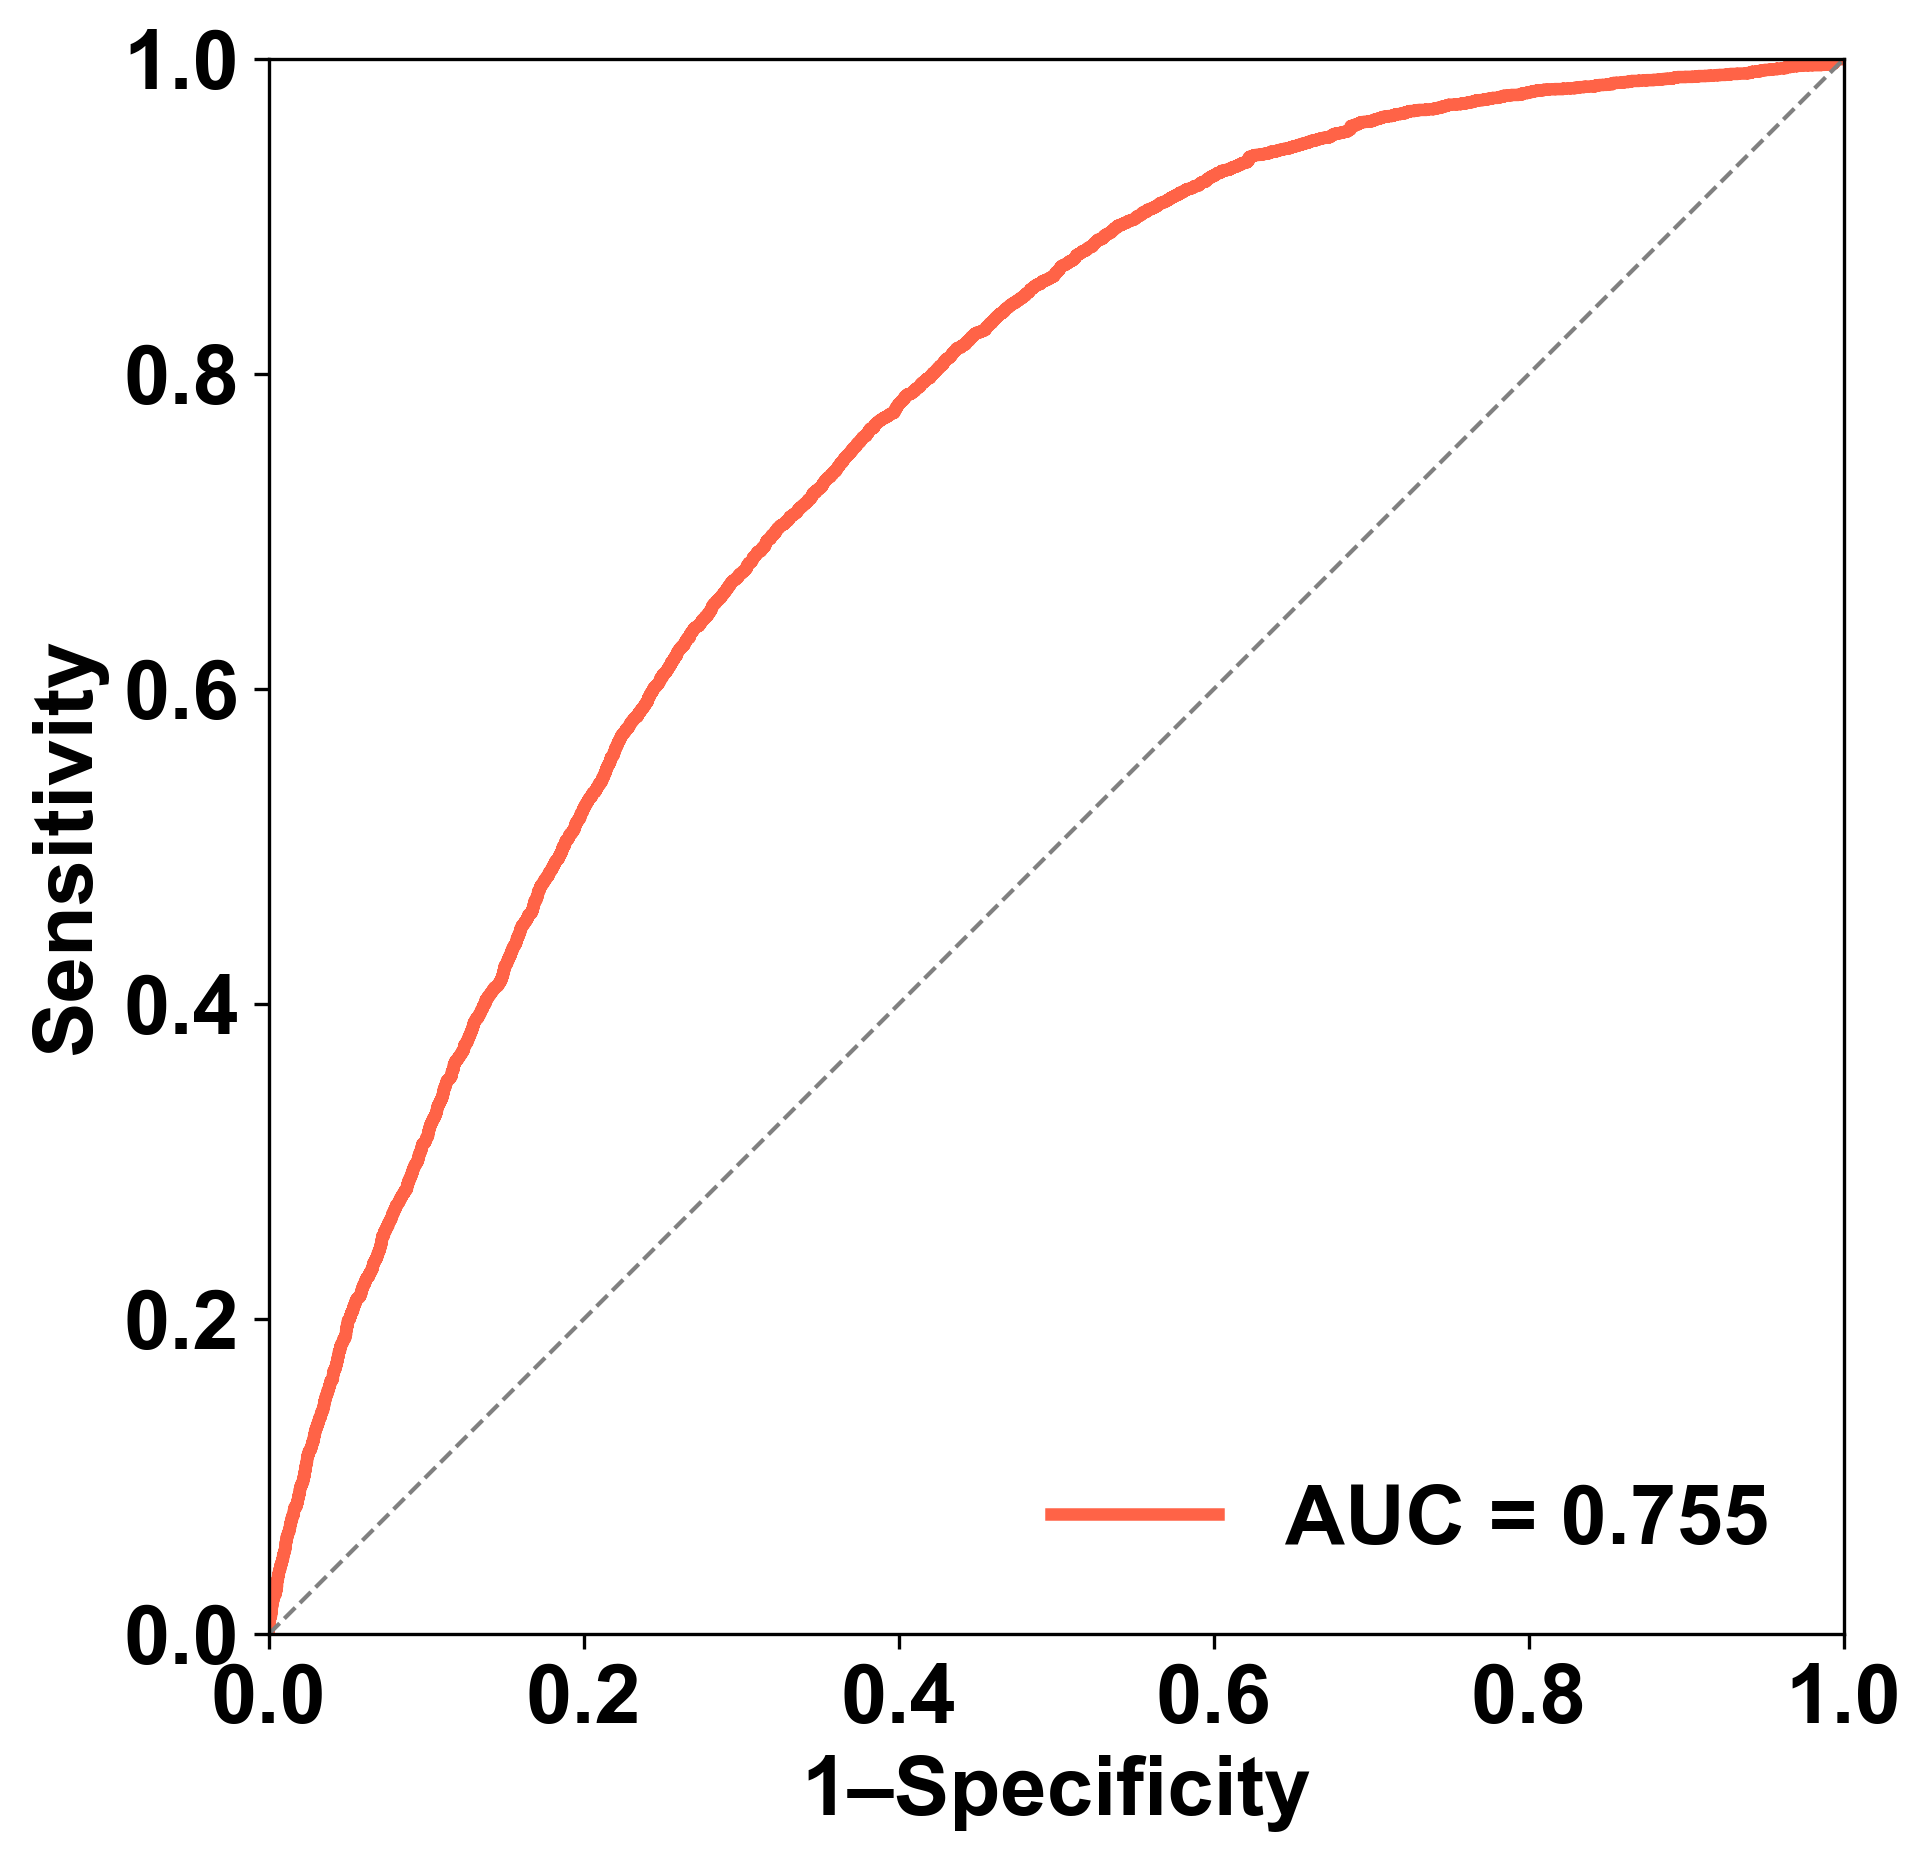

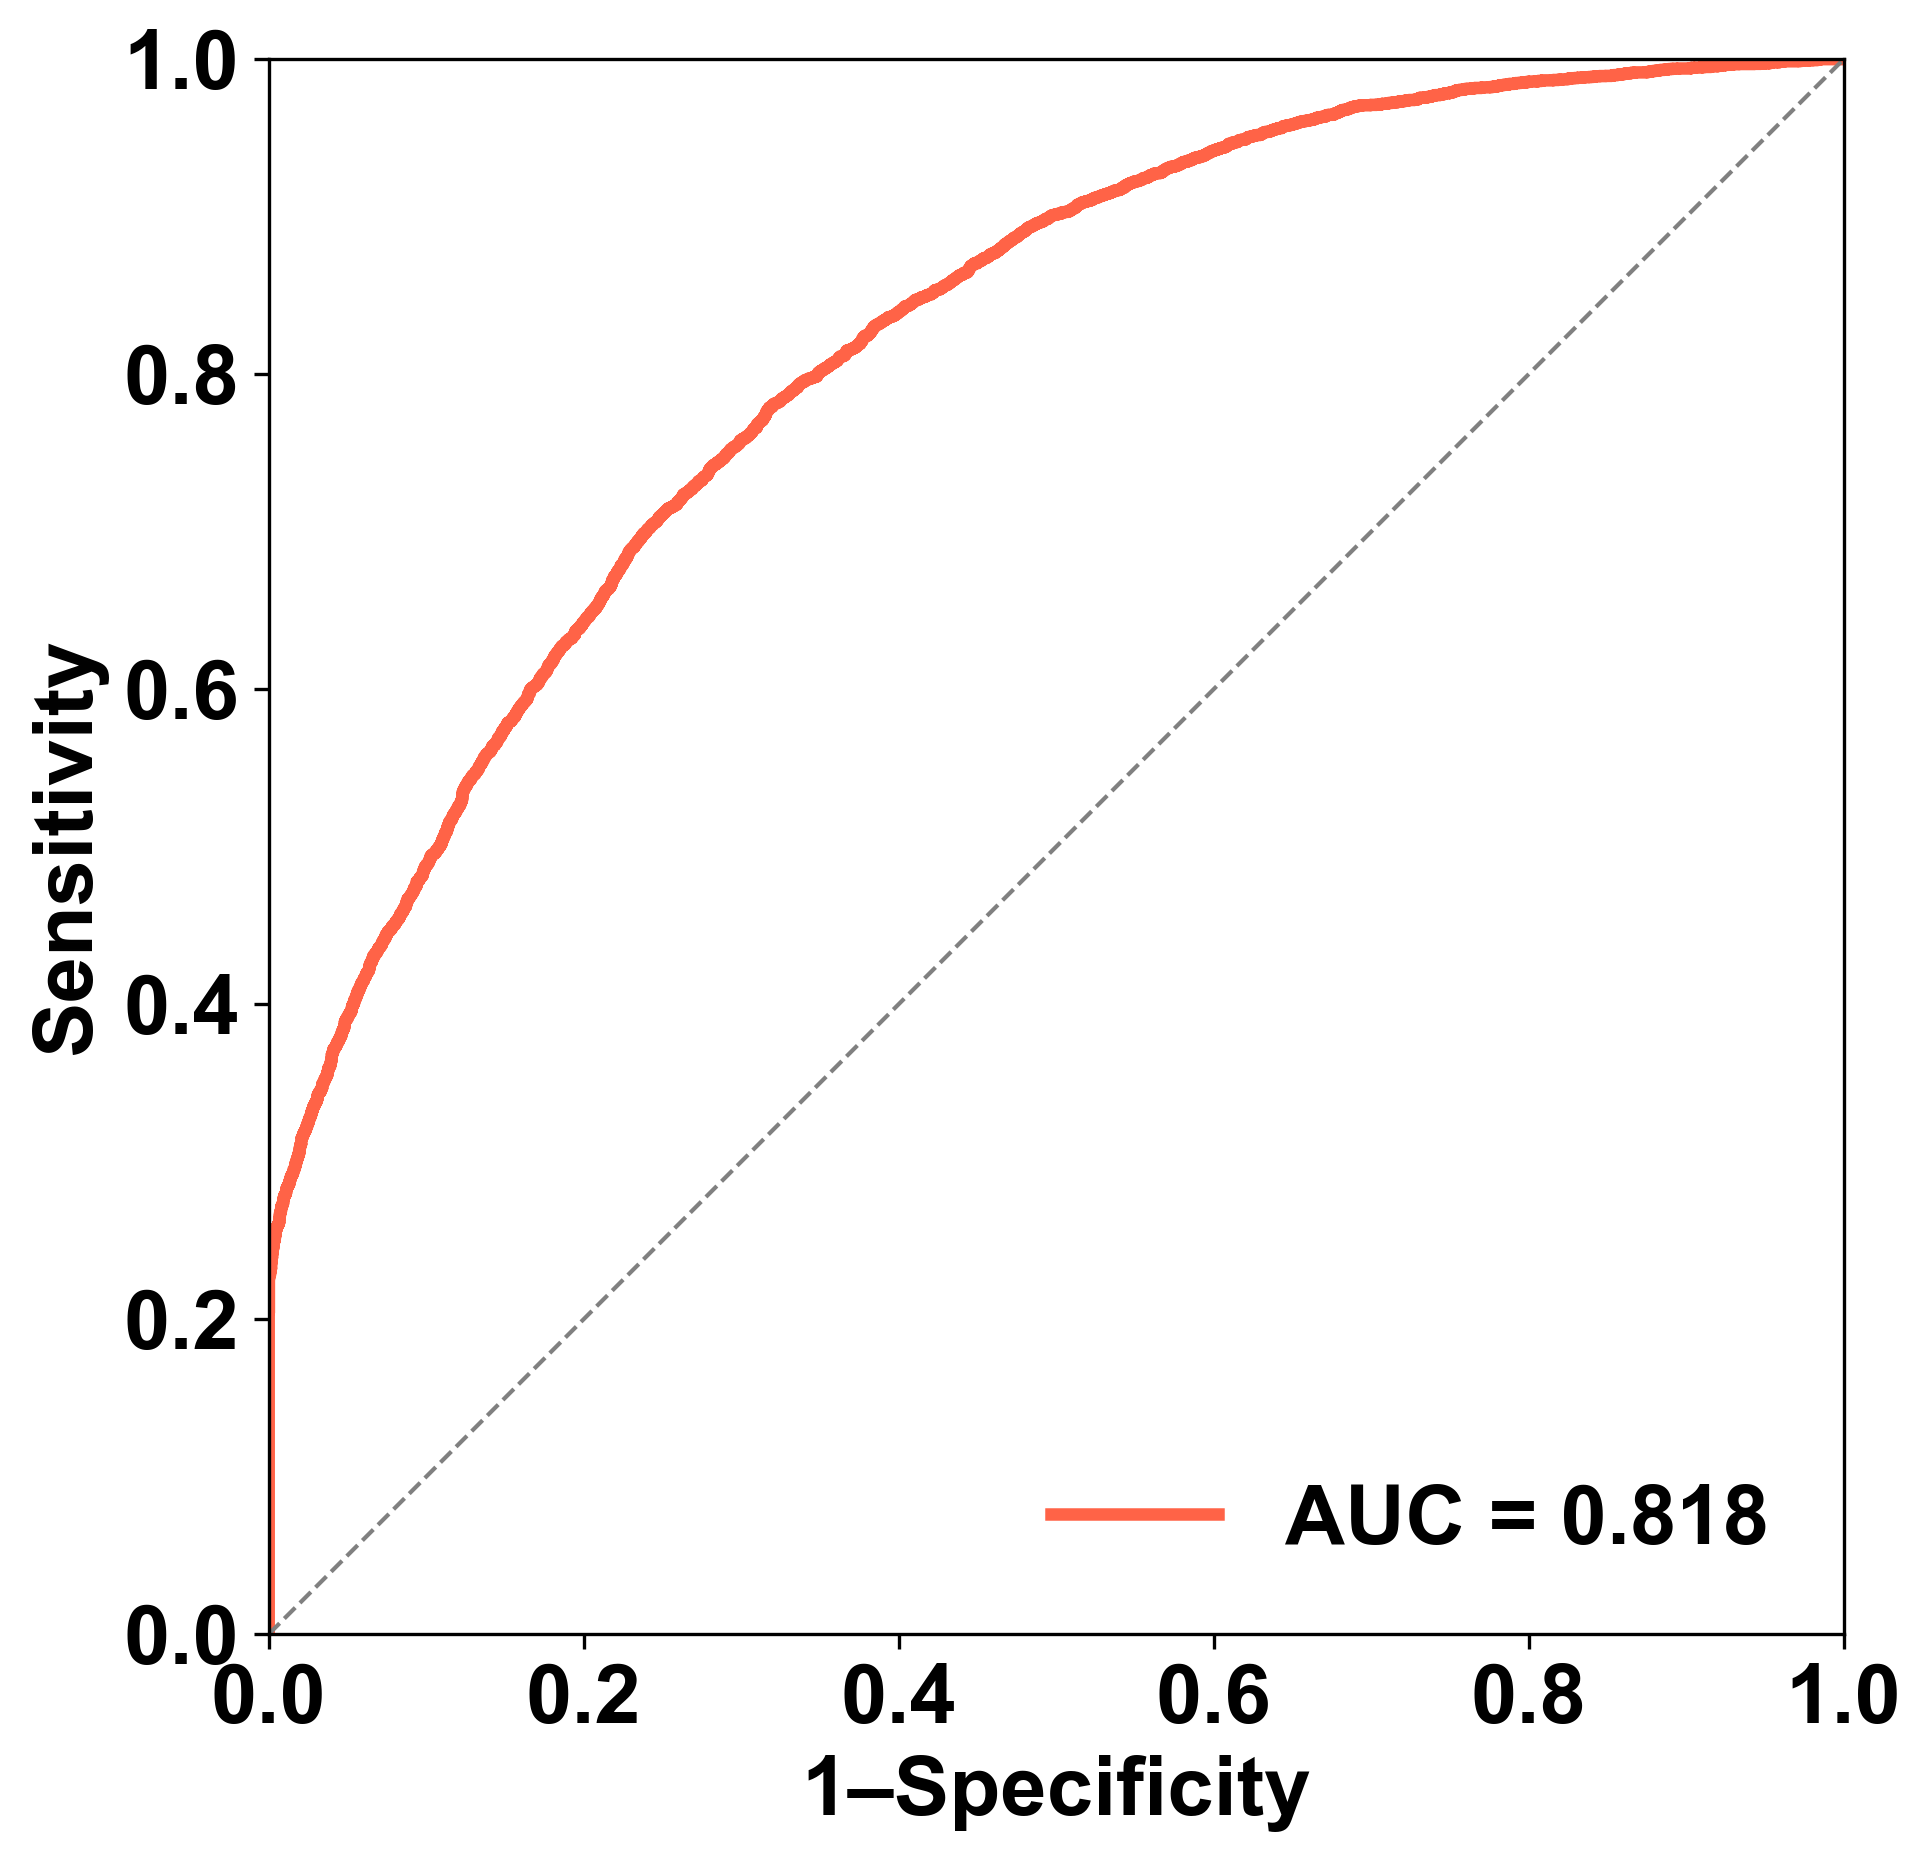

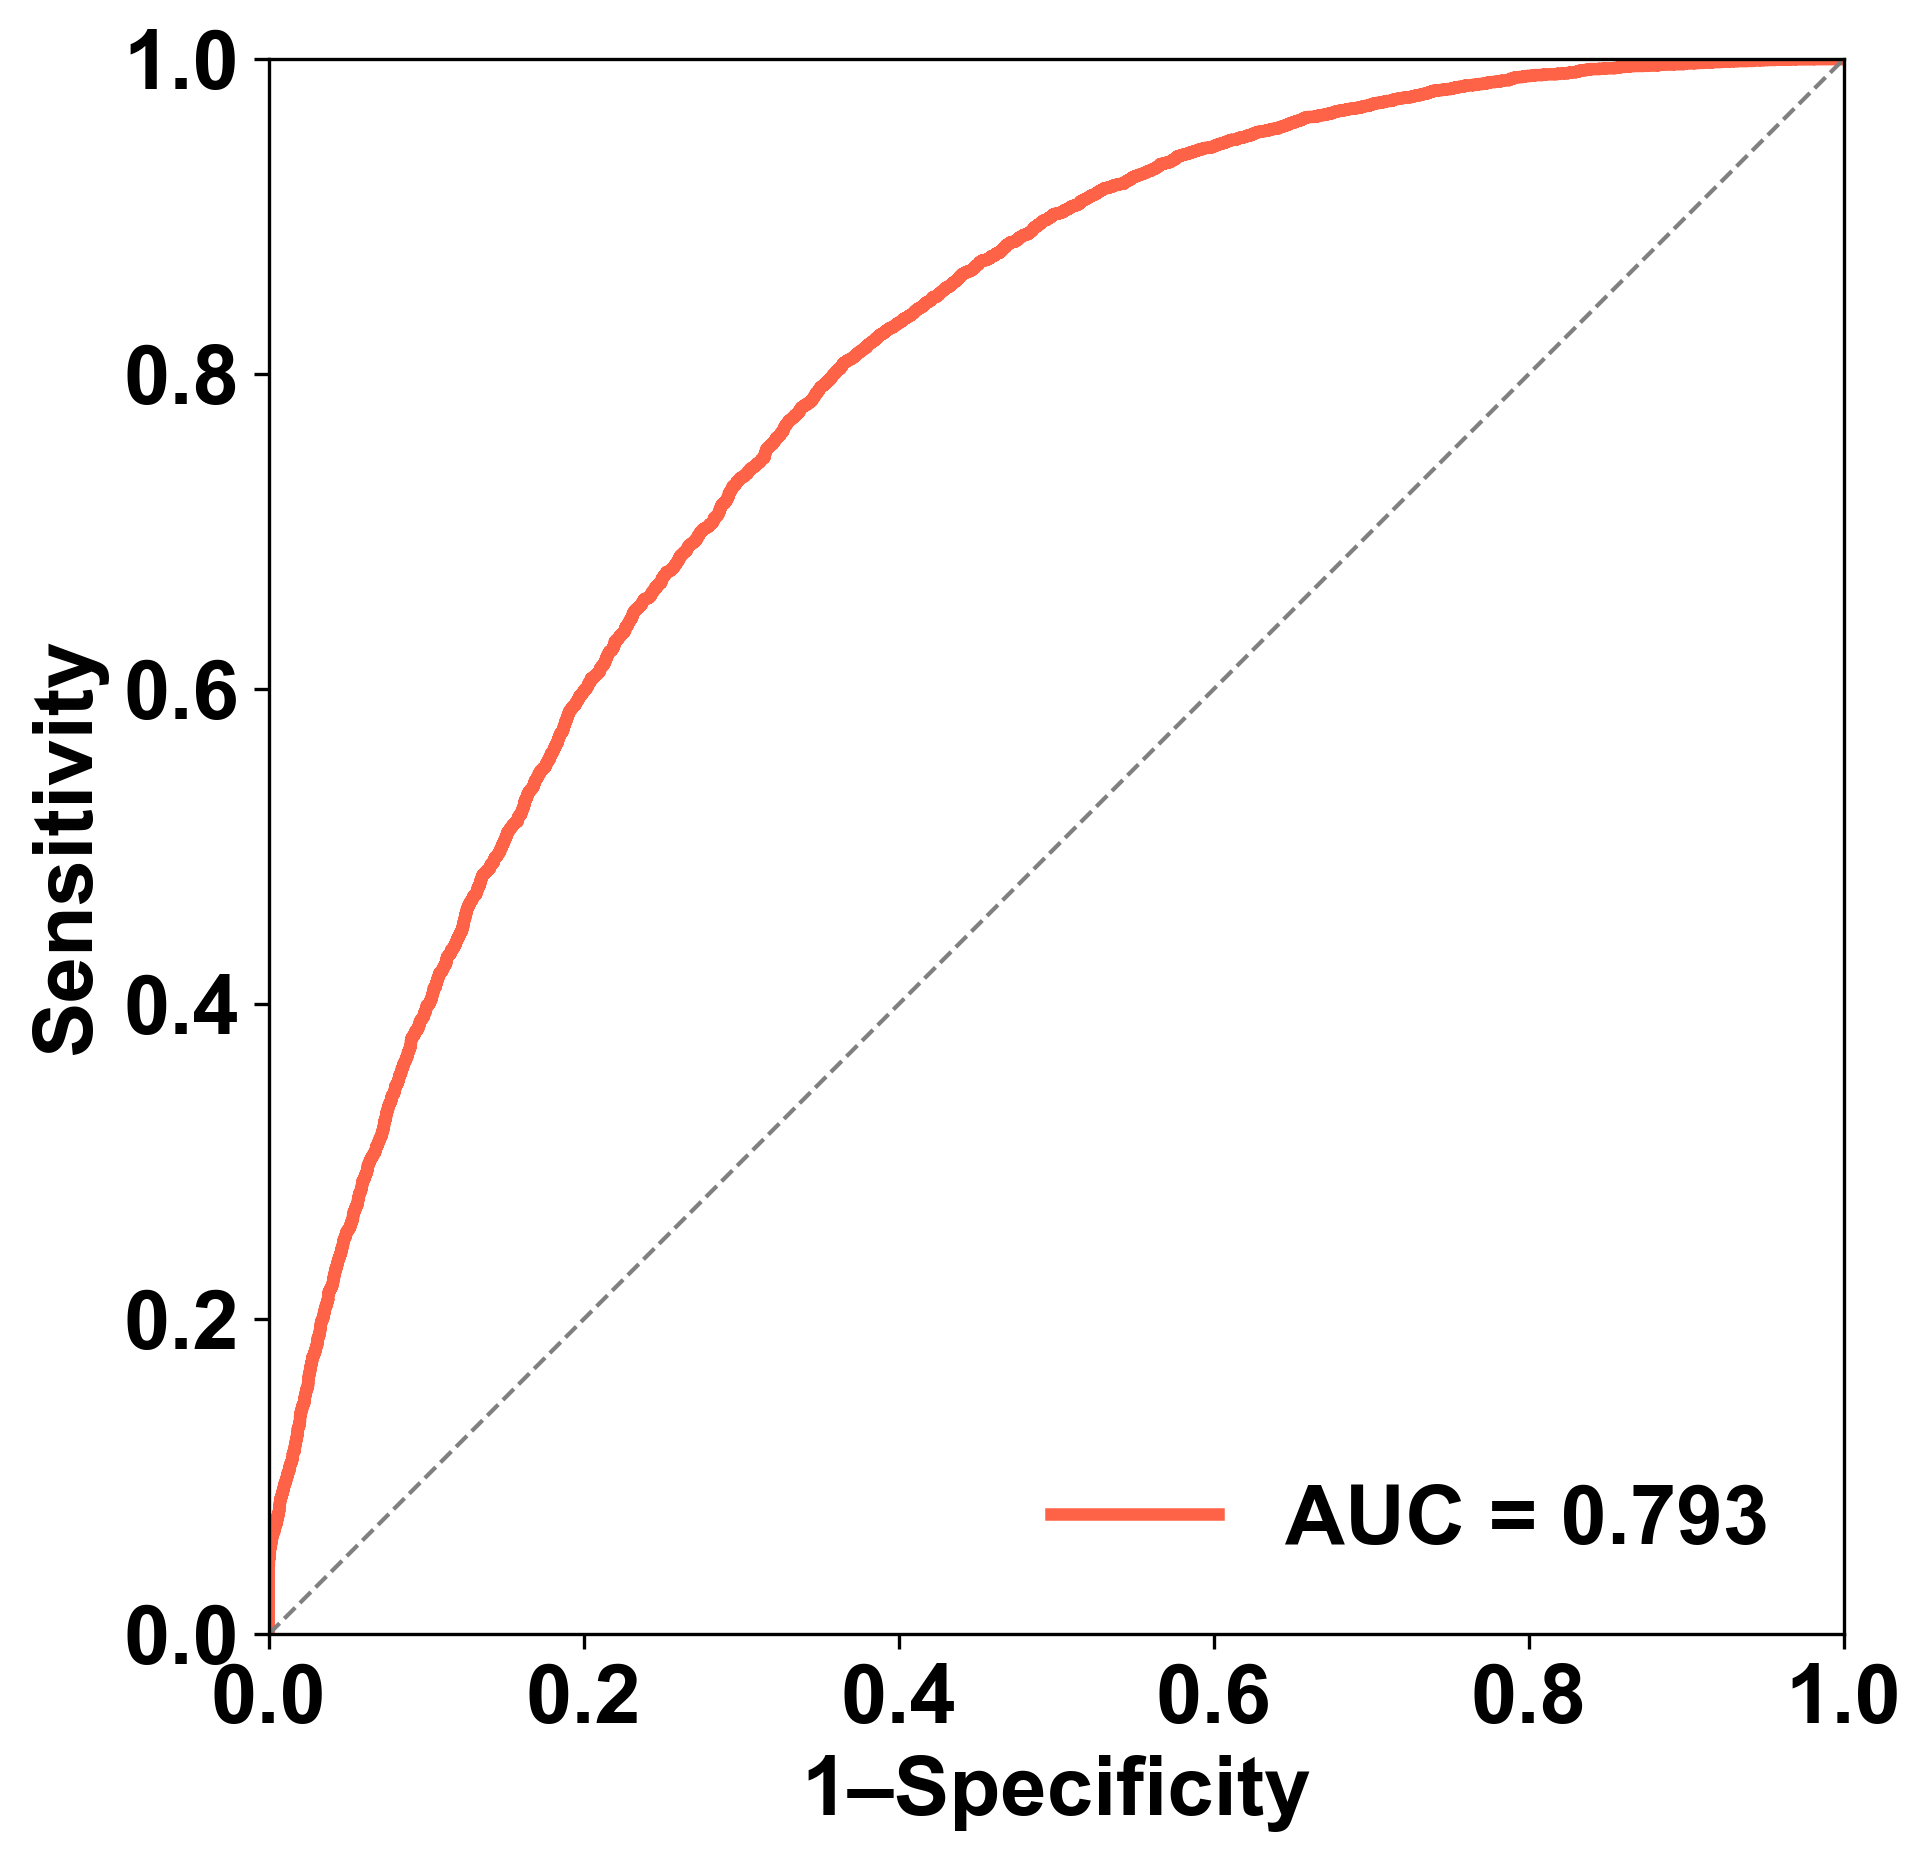

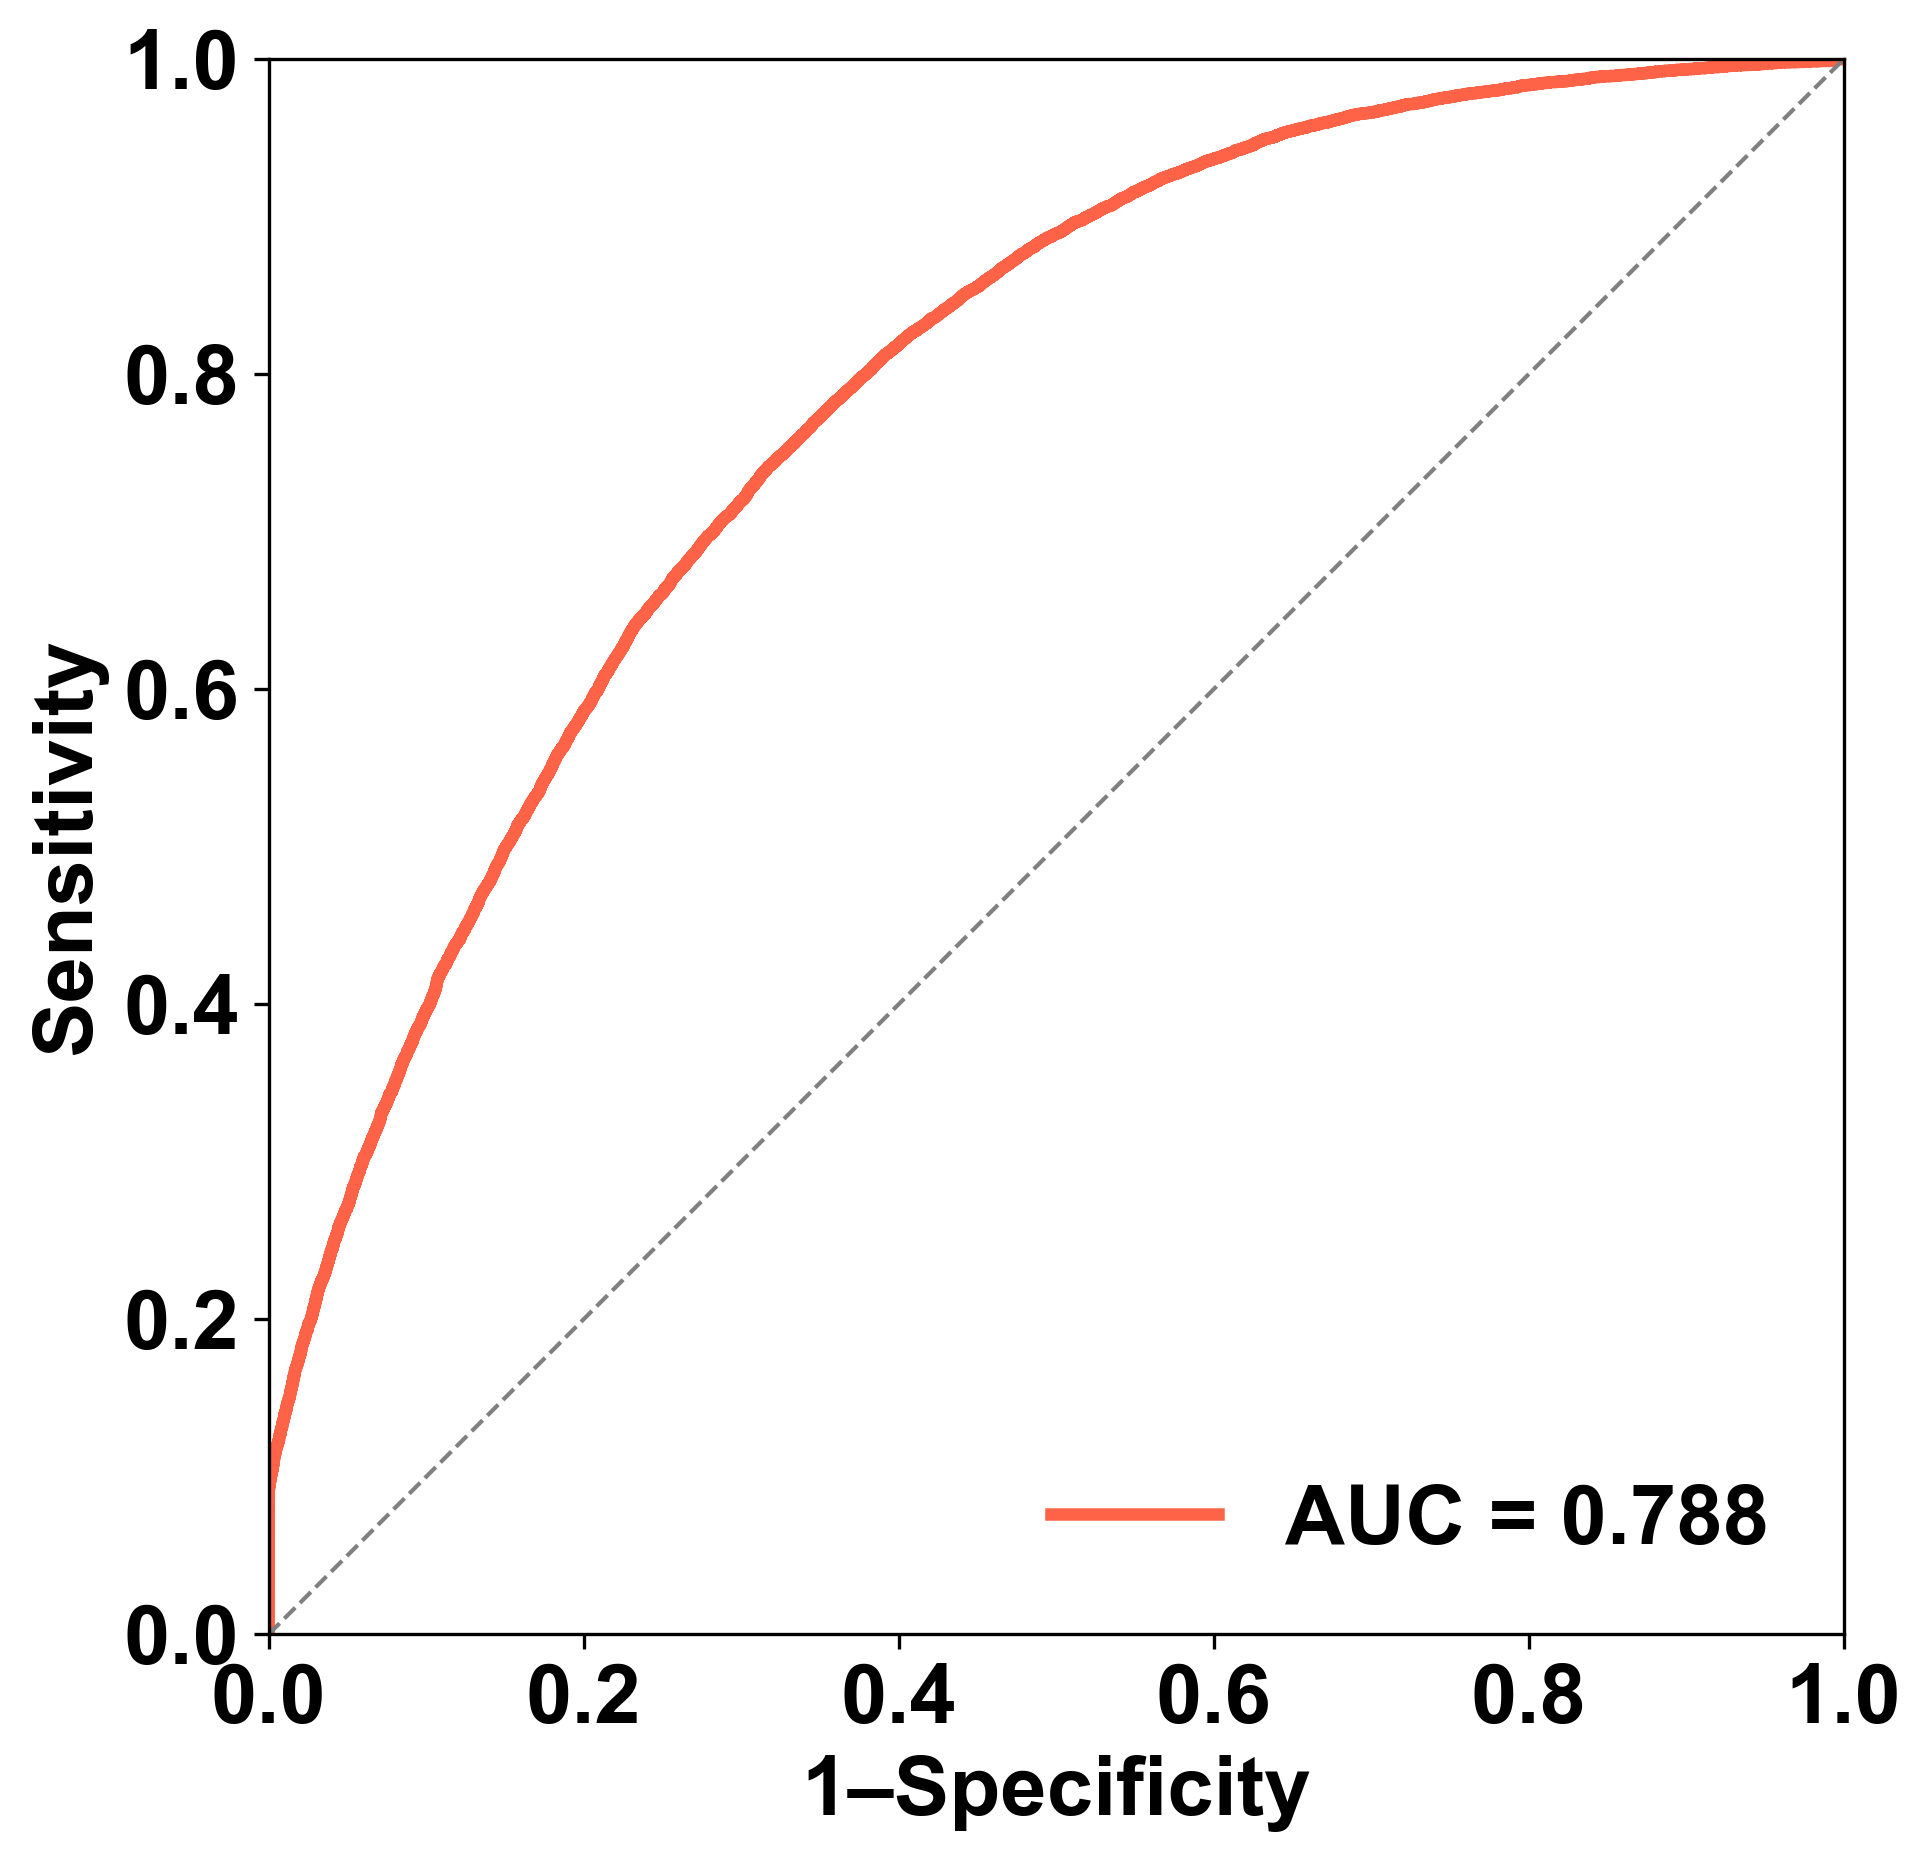

In [8]:
if __name__ == '__main__':
    '''读取数据'''
    vocab_size = 600  # Only consider the top 20k words

    maxlen = 21
    '''搭建模型'''
    embed_dim = 128  # Embedding size for each token
    num_heads = 4  # Number of attention heads
    ff_dim = 64  # Hidden layer size in feed forward network inside transformer

    inputs = layers.Input(shape=(maxlen,))
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
    x = transformer_block(x, training=True)

    x = layers.GlobalAveragePooling1D()(x)
    O_seq = Dropout(0.05)(x)
    print(O_seq.shape)
    O_seq = Dense(64, activation='selu')(O_seq)

    O_seq = Dense(16, activation='selu')(O_seq)
    O_seq = Dropout(0.1)(O_seq)

    outputs = Dense(2, activation='softmax')(O_seq)

    model = Model(inputs=inputs, outputs=outputs)

    print(model.summary())

    data, labels = prepare_data()
    data = seq2num(data)

    count = 0

    sfolder = StratifiedKFold(n_splits=3, shuffle=False)
    all_loc_pred = []
    all_loc_label = []
    for train, test in sfolder.split(data, labels):
        xtrain_pos = np.zeros((1, maxlen))
        ytrain_pos = []
        count += 1
        x_train, x_test = data[train], data[test]
        y_train, y_test = labels[train], labels[test]

        y_train = np.array(to_categorical(y_train))
        y_test = np.array(to_categorical(y_test))

        model.compile(
            loss='binary_crossentropy',
            optimizer=Adam(learning_rate=0.0001),
            metrics=['accuracy'])

        print('----------------training-----------------------')

        model.fit(x_train, y_train,
                  batch_size=64,
                  epochs=50,
                  validation_data=(x_test, y_test)
                  )

        print('----------------testing------------------------')
        loss, accuracy = model.evaluate(x_test, y_test)
        print('\n test loss:', loss)
        print('\n test accuracy', accuracy)
        
        #model.save_weight(f'./site_models/transformer_{count}.h5')
        model.save(f'./site_models/transformer_{count}.h5')
        #reset_keras()
        #model = load_model(f'./site_models/transformer_{count}.keras')

        predicts = list(model.predict(x_test)[:, 1])
        roc(list([list(i)[1] for i in y_test]), predicts)
        all_loc_pred += predicts
        all_loc_label += list([list(i)[1] for i in y_test])
        #reset_keras()

    roc(all_loc_label, all_loc_pred)

In [9]:
print(model.summary())

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 21)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, 21, 128)             │          79,488 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 21, 128)             │          83,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 515,864 (1.97 MB)

 Trainable params: 171,954 (671.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 343,910 (1.31 MB)

None


In [10]:
# transformer—features

In [11]:
import os.path

import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import AUC
from keras.optimizers import Adam, RMSprop
from keras.preprocessing import sequence
from keras.datasets import imdb
from keras.models import Model
from keras.layers import *
import keras.backend as K
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from sklearn import metrics
import matplotlib.pyplot as plt
from keras.models import load_model
import matplotlib.pylab as pylab
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from tensorflow.keras.metrics import AUC
from keras.optimizers import Adam, RMSprop
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
import re


In [12]:
def prepare_data1(transfer_or_not):
    if transfer_or_not:
        path = './transfer'
    else:
        path = './results'
    df = pd.read_csv(path + '/Khib_label.csv')
    pepname = df['pepname']
    label = df['label']

    def seq_dic(fileplace):
        with open(fileplace, mode='r') as file:
            peptides = file.readlines()
            pepdict = {}
            for peptide in peptides:
                peptide = peptide.rstrip().split('\t')
                pepdict[peptide[0]] = peptide[1]
        return pepdict

    pos_dict = seq_dic(path + '/pos_Khib.txt')
    neg_dict = seq_dic(path + '/neg_Khib.txt')

    pep_seq = []
    for i, pepID in enumerate(pepname):
        if label[i] == 0:
            pep_seq.append(neg_dict[pepID])
        else:
            pep_seq.append(pos_dict[pepID])

    return np.array(pepname), np.array(pep_seq), label

In [13]:
def store_code1(peplist, codes, labels, transfer_or_not):
    for i, la in enumerate(labels):
        if transfer_or_not:
            storehouse = './transfer'
        else:
            storehouse = './results'
        if la == 0:
            storehouse = storehouse + '/negative/'
        else:
            storehouse = storehouse + '/transformer/'
        
        if not os.path.exists(storehouse):
            os.makedirs(storehouse)
        try:
            with open(storehouse + str(peplist[i]) + r'.transformer', mode='w') as file:
                for co in codes[i]:
                    file.write(str(co) + '\t')
                file.write('\n')
        except Exception as e:
            print(f"Error writing to file: {e}")

In [14]:
# encoding transfer-learning data or pre-training data
#'''
trans_or_not = False
namelist, data, label = prepare_data1(trans_or_not)

data = seq2num(data)
#count = 3 #np.random.randint(1, 10)

#model = load_model(f'./site_models/transformer_%s.keras' % count)

model.summary()
dropout_2_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('dropout_2').output)
dropout_2_output = dropout_2_model.predict(x=data, batch_size=128)

store_code1(namelist, dropout_2_output, label, trans_or_not)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 21)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, 21, 128)             │          79,488 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 21, 128)             │          83,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 515,864 (1.97 MB)

 Trainable params: 171,954 (671.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 343,910 (1.31 MB)

380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [15]:
def getfeatures1(namelist, labels):
    feature = []
    for i, name in enumerate(namelist):
        if labels[i] == 0:
            fileplace = 'E:/NingLab/object/khib/results/negative/'
        else:
            fileplace = 'E:/NingLab/object/khib/results/transformer/'
        with open(fileplace + name + '.transformer', mode='r') as file:
            fea = file.read().rstrip().split('\t')
            fea = turn_to_float64(fea)
            feature.append(fea)
    return np.array(feature)

In [16]:
def turn_to_float64(feature):
    x = np.array(list(feature), dtype=np.float64)
    y = x.tolist()
    return y

In [17]:
# '''
# turn transformer feature in to csv for pre-training data
#'''
trans_or_not = False
namelist, data, label = prepare_data1(trans_or_not)
transformer_feature = getfeatures1(namelist, label)
df_trans = pd.DataFrame(transformer_feature)
df_peps = pd.DataFrame(namelist, columns=['pepname'])
df_labels = df_label = pd.DataFrame(label, columns=['label'])
df_transformer = pd.concat([df_peps, df_trans, df_label], axis=1)
df_transformer.to_csv('E:/NingLab/object/khib/results/transformer_dataset1.csv', index=False)
# '''

In [18]:
# encoding transfer-learning data 
#'''
trans_or_not = True
namelist, data, label = prepare_data1(trans_or_not)
data = seq2num(data)
#count = 3 #np.random.randint(1, 10)

#model = load_model(f'./site_models/transformer_%s.keras' % count)

model.summary()
dropout_2_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('dropout_2').output)
dropout_2_output = dropout_2_model.predict(x=data, batch_size=128)

store_code1(namelist, dropout_2_output, label, trans_or_not)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 21)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, 21, 128)             │          79,488 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 21, 128)             │          83,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 515,864 (1.97 MB)

 Trainable params: 171,954 (671.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 343,910 (1.31 MB)

186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [19]:
def getfeatures2(namelist, labels):
    feature = []
    for i, name in enumerate(namelist):
        if labels[i] == 0:
            fileplace = 'E:/NingLab/object/khib/transfer/negative/'
        else:
            fileplace = 'E:/NingLab/object/khib/transfer/transformer/'
        with open(fileplace + name + '.transformer', mode='r') as file:
            fea = file.read().rstrip().split('\t')
            fea = turn_to_float64(fea)
            feature.append(fea)
    return np.array(feature)

In [20]:
# '''
# turn transformer feature in to csv for transfer-learning 
#'''
trans_or_not = True
namelist, data, label = prepare_data1(trans_or_not)
transformer_feature = getfeatures2(namelist, label)
df_trans = pd.DataFrame(transformer_feature)
df_peps = pd.DataFrame(namelist, columns=['pepname'])
df_labels = df_label = pd.DataFrame(label, columns=['label'])
df_transformer = pd.concat([df_peps, df_trans, df_label], axis=1)
df_transformer.to_csv('E:/NingLab/object/khib/transfer/transformer_dataset.csv', index=False)

In [21]:
def prepare_data2():
    pep_dict = {}
    pep_seq = []

    with open('./transfer/experiment_sites.txt', mode='r') as file:
        lines = file.readlines()
        for line in lines:
            pepname, seq = line.rstrip().split('\t')
            pep_dict[pepname] = seq
            pep_seq.append(seq)

    return np.array(list(pep_dict.keys())), np.array(pep_seq)

In [22]:
def store_code2(peplist, codes):
    for i, pepname in enumerate(peplist):
        storehouse = './transfer/experiment/transformer/'
        if not os.path.exists(storehouse):
            os.makedirs(storehouse)
        with open(storehouse + pepname + r'.transformer', mode='w') as file:
            for co in codes[i]:
                file.write(str(co) + '\t')
            file.write('\n')

In [24]:
# encoding experiment data for predicting
namelist, data = prepare_data2()
data = seq2num(data)
#count = 3
#model = load_model(f'./models/transformer/transformer_%s.model' % count)
model.summary()
dropout_2_model = tf.keras.models.Model(inputs=model.input, outputs=model.get_layer('dropout_2').output)
dropout_2_output = dropout_2_model.predict(x=data, batch_size=128)
store_code2(namelist, dropout_2_output)
# '''

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 21)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, 21, 128)             │          79,488 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 21, 128)             │          83,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 515,864 (1.97 MB)

 Trainable params: 171,954 (671.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 343,910 (1.31 MB)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


In [25]:
def getfeatures3(namelist):
    feature = []
    for i, name in enumerate(namelist):
        fileplace = 'E:/NingLab/object/khib/transfer/experiment'
        with open(fileplace + '/transformer/' + name + '.transformer', mode='r') as file:
            fea = file.read().rstrip().split('\t')
            fea = turn_to_float64(fea)
            feature.append(fea)
    return np.array(feature)

In [26]:
# turn transformer feature in to csv for predicting
namelist, data = prepare_data2()
transformer_feature = getfeatures3(namelist)
df_trans = pd.DataFrame(transformer_feature)
df_peps = pd.DataFrame(namelist, columns=['pepname'])
df_transformer = pd.concat([df_peps, df_trans], axis=1)
df_transformer.to_csv('./transfer/experiment/transformer_dataset.csv', index=False)
# '''